In [27]:
from model.LongTermAccompaniment import LongTermAccompaniment
from model import load_model
import torch
from hvo_sequence.hvo_seq import HVO_Sequence
from hvo_sequence.drum_mappings import ROLAND_REDUCED_MAPPING
from bokeh.plotting import show, output_notebook


# 

In [28]:
# load data

from data import PairedLTADataset

test_dataset = PairedLTADataset(
        input_inst_dataset_bz2_filepath="data/lmd/data_bass_groove_test.bz2",
        output_inst_dataset_bz2_filepath="data/lmd/data_drums_full_unsplit.bz2",
        shift_tgt_by_n_steps=1,
        max_input_bars=32,
        continuation_bars=2,
        hop_n_bars=2,
        input_has_velocity=True,
        input_has_offsets=True
    )

test_dataset.__len__()

INFO:data.Base.dataLoaders:PairedLTADatasetV2 Constructor --> Loading Cached Version from: cached/TorchDatasets/PairedLTADataset_data_bass_groove_test.bz2_data_drums_full_unsplit.bz2_32_2_True_True_1.bz2pickle


14766

In [29]:
from tqdm import tqdm

def calculate_jaccard(seg1, seg2):
    val = torch.sum(seg1 * seg2) / torch.sum(torch.clip_(seg1 + seg2, 0, 1)).item()
    # set to zero if nan
    return 0 if torch.isnan(val) else val

def calculate_mse(seg1, seg2):
    return 1-torch.functional.F.mse_loss(seg1, seg2).item()

def extract_segs(hvo):
    segs = []
    bars = hvo.shape[0] // 32
    for i in range(bars):
        segs.append(hvo[i*32:(i+1)*32,: ])
    return segs

def cross_similarity_heat_map(segs):
    corr_h = torch.zeros((len(segs), len(segs)))
    corr_v = torch.zeros((len(segs), len(segs)))
    corr = torch.zeros((len(segs), len(segs)))
    for i in range(len(segs)):
        for j in range(len(segs)):
            if i!=j:
                h1 = segs[i][:, 0:1] if segs[i].shape[-1] == 3 else segs[i][:, 0:9]
                h2 = segs[j][:, 0:1] if segs[j].shape[-1] == 3 else segs[j][:, 0:9]
                v1 = segs[i][:, 1:2] if segs[i].shape[-1] == 3 else segs[i][:, 9:18]
                v2 = segs[j][:, 1:2] if segs[j].shape[-1] == 3 else segs[j][:, 9:18]
                corr_h[i, j] = calculate_jaccard(h1, h2)
                corr_v[i, j] = calculate_mse(v1, v2)
                corr[i, j] = (corr_h[i, j] * corr_v[i, j]) 
    total_corr = torch.sum(corr, dim=1)
    normalized_total_corr = total_corr / torch.sum(total_corr)
    average_corr = torch.mean(total_corr)
    return corr, normalized_total_corr, average_corr

def calc_cross_sims(hvos):
    segs = [extract_segs(hvo) for hvo in hvos]
    sims = []
    ncs = []
    tot_corrs = []
    for i in tqdm(range(len(segs)), desc="Calculating similarities", total=len(segs)):
        sim, nc, tot_corr = cross_similarity_heat_map(segs[i])
        sims.append(sim)
        ncs.append(nc)
        tot_corrs.append(tot_corr)
        
    # normalize total correlations
    tot_corrs = torch.tensor(tot_corrs)
    tot_corrs = (tot_corrs) / (torch.max(tot_corrs))
    
    return sims, ncs, tot_corrs

sims, ncs, tot_corrs = calc_cross_sims(test_dataset.instrument1_hvos)


Calculating similarities: 100%|██████████| 14766/14766 [04:10<00:00, 58.87it/s]


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f53f1ab68b0>


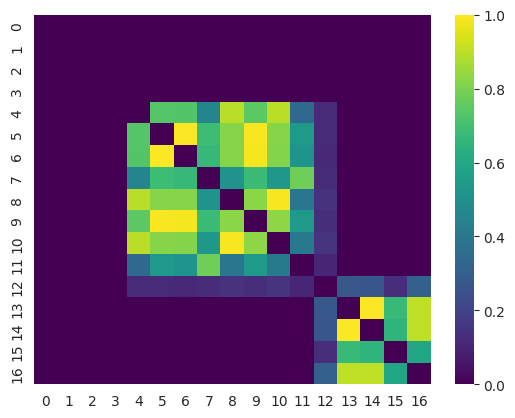

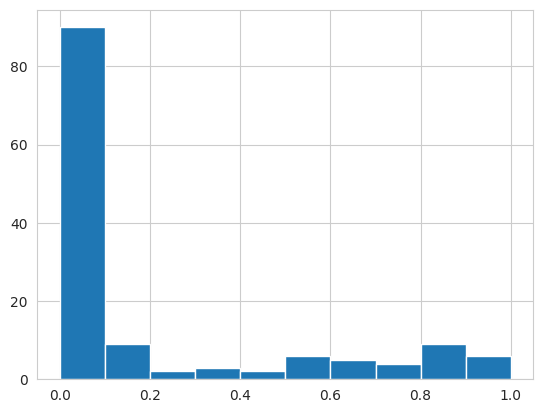

(12576, tensor(0.1957))

In [462]:
# plot a heatmap with corr of 0.1
import matplotlib.pyplot as plt
import seaborn as sns

# find closest index to 0.1
min_diff = 1
min_diff_idx = 0
tgt_corr = 0.16 + (0.1 * torch.rand(1))
for i in range(len(tot_corrs)):
    diff = abs(tot_corrs[i] - tgt_corr)
    if diff < min_diff:
        min_diff = diff
        min_diff_idx = i

# plot the heatmap
sns.heatmap(sims[min_diff_idx], cmap="viridis", vmin=0, vmax=1)
# set colorbar to show 0 to 1
# ...
plt.show()

upper_tri = torch.triu(sims[min_diff_idx], diagonal=1)
indices = torch.triu_indices(row=upper_tri.shape[0], col=upper_tri.shape[1], offset=1)
vals = sims[min_diff_idx][indices[0], indices[1]]
# plot histogram of vals
plt.hist(vals, bins=10, range=(0, 1),density=False)
plt.show()

min_diff_idx, tot_corrs[min_diff_idx]

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f53f3a537c0>


tensor([121])


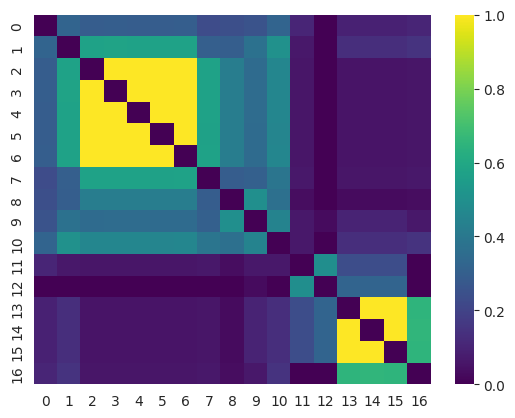

(tensor([4737]), tensor([0.2907]))

In [437]:

# plot a heatmap with corr of 0.1
import matplotlib.pyplot as plt
import seaborn as sns

# find closest index to 0.1
min_diff = 1
min_diff_idx = 0
tgt_corr = 0.3


diffs = tot_corrs - tgt_corr
# randomly grab 1 with a tolerance of 0.01
min_diff_idx = torch.where(torch.abs(diffs) < 0.01)
ix = torch.randint(0, len(min_diff_idx[0]), (1,))
min_diff_idx = min_diff_idx[0][ix]

print(ix)


# plot the heatmap
sns.heatmap(sims[min_diff_idx], cmap="viridis", vmin=0, vmax=1)
plt.show()

min_diff_idx, tot_corrs[min_diff_idx]

In [436]:
ncs[0]

tensor([0.0156, 0.0274, 0.0561, 0.0639, 0.0645, 0.0658, 0.0615, 0.0673, 0.0645,
        0.0673, 0.0658, 0.0643, 0.0616, 0.0641, 0.0611, 0.0671, 0.0620])

In [347]:
# count zeros in the heatmap 
super_sim = torch.sum((sims[10]) >= 0.9) - sims[0].shape[0]

# count super sims in upper triangle
upper_tri = torch.triu(sims[10], diagonal=1)
n_seg_pairs = torch.triu(torch.ones_like(sims[10]), diagonal=1).sum()
super_sim_upper = torch.sum(upper_tri >= 0.7) / n_seg_pairs
low_sim_upper = torch.sum(upper_tri <= 0.3) / n_seg_pairs

# create upper triangle mask
super_sim_upper, low_sim_upper

(tensor(0.4412), tensor(1.1250))